In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

/home/arnaudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


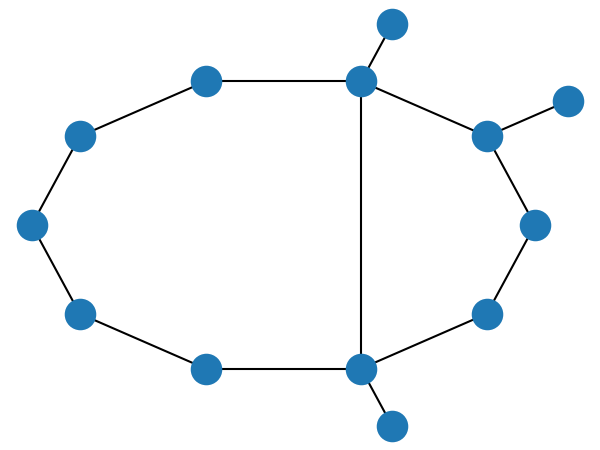

/home/arnaudon/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

<IPython.core.display.Javascript object>


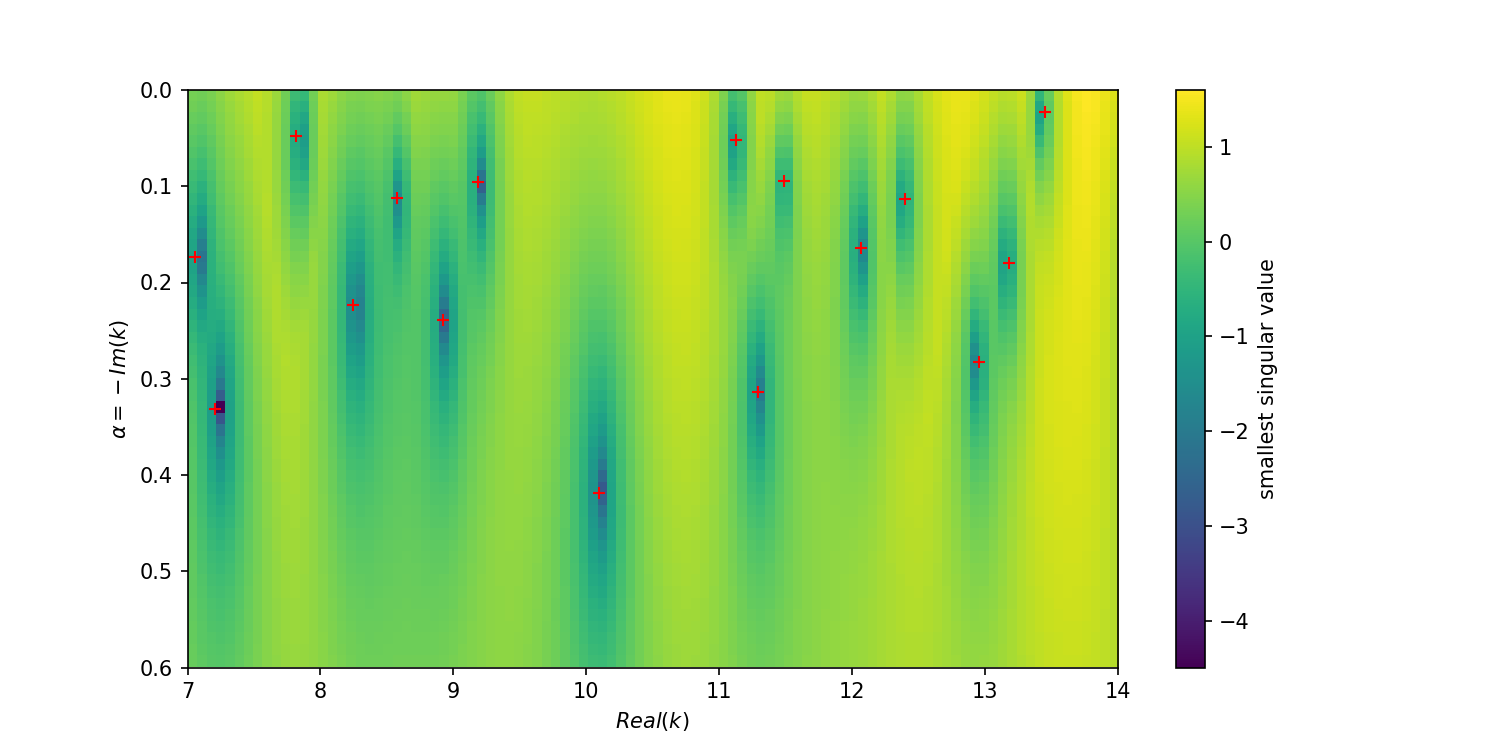

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


In [6]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 1.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [0, 1, 2, 3, 4, 5, 10]  #edges to pump

m = 0
naq_u1.update_chi(modes[m])
print("condition number no pump:", naq_u1.test_laplacian())

naq_u1.pump_params['D0']         = 1e-2
naq_u1.update_chi(modes[m])
print("condition number with pump:", naq_u1.test_laplacian())


condition number no pump: 9.1459566e-05
condition number with pump: 0.20054668


In [7]:
#find the pump trajectories
params['s_size']    = 1e-2*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .1
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 9/9 [00:22<00:00,  2.55s/it]


<IPython.core.display.Javascript object>


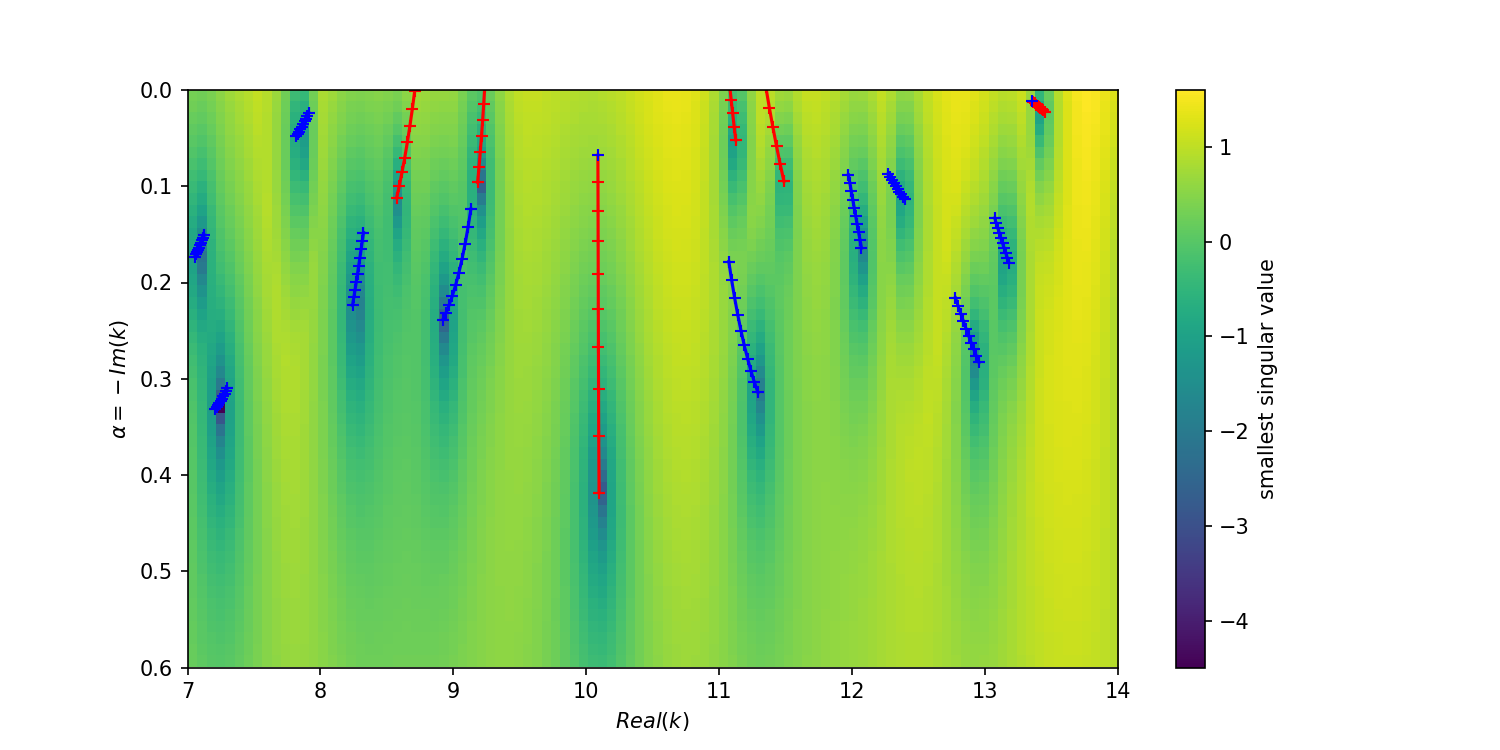

In [8]:
#plot the pump trajectories
naq_u1.plot_pump_traj(Ks, Alphas, s, modes, new_modes)

In [9]:
params['s_size']    = 5e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 18/18 [01:12<00:00,  5.34s/it]


<IPython.core.display.Javascript object>


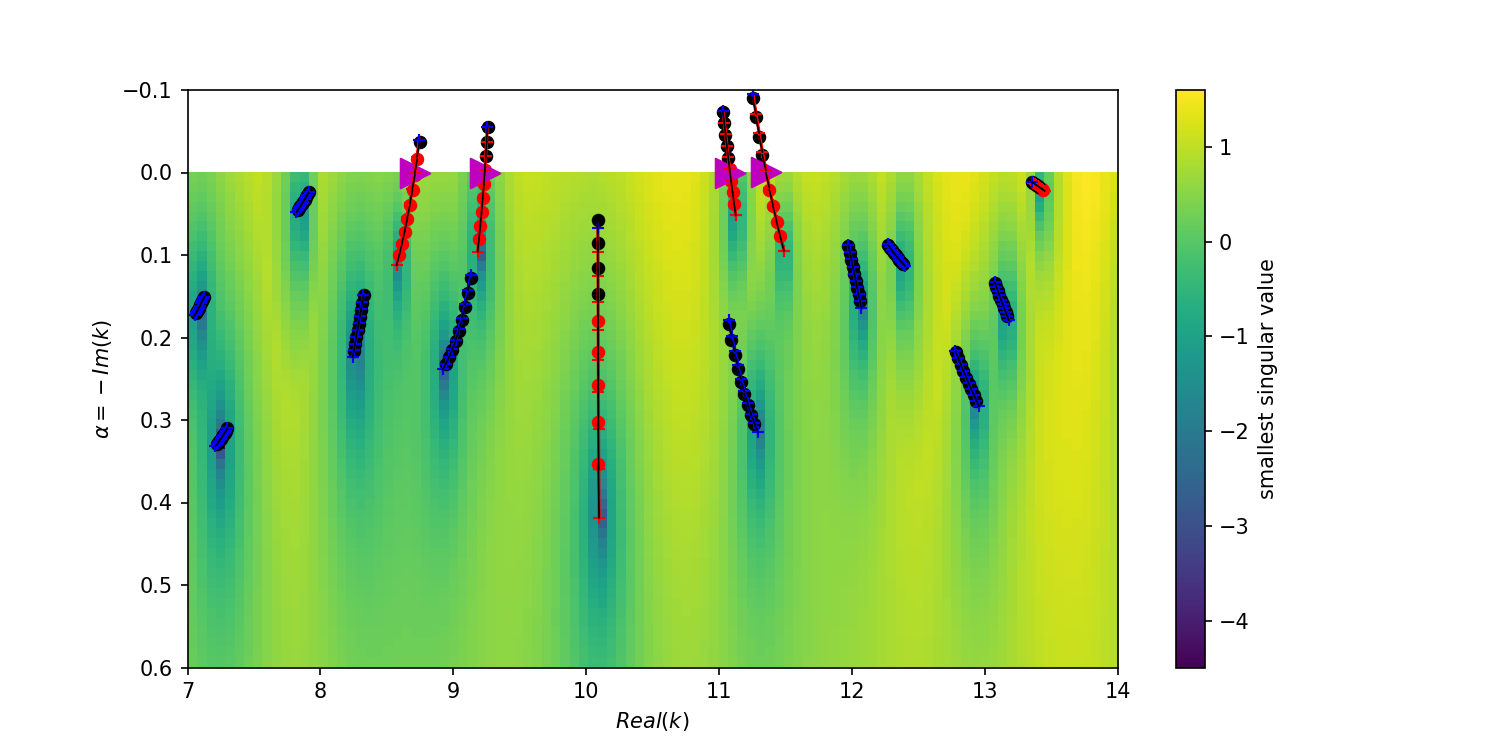

In [10]:
#plot the trajectories and the lasing modes

naq_u1.plot_pump_traj(  Ks, Alphas, s, modes, new_modes, estimate=True)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.1])

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
#plt.axis([13.3, 13.5, 0.03, -0.01])
plt.show()

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later

In [11]:
D0 = 0.06
th_modes_selec = []
D0_th_selec = []
for i, m in enumerate(th_modes):
    if type(m) == np.ndarray:
        th_modes_selec.append(m)
        D0_th_selec.append(D0_th[i])
        
th_modes_selec = np.asarray(th_modes_selec)
D0_th_selec = np.asarray(D0_th_selec)
print(th_modes_selec)
print(D0_th_selec)

[[ 1.10842063e+01  4.90755864e-05]
 [ 1.13566439e+01 -9.52288855e-05]
 [ 9.23603612e+00  6.34626972e-05]
 [ 8.71101032e+00  3.53190827e-05]]
[0.04115716 0.05413969 0.06469277 0.07812096]


In [30]:
def T_matrix(self, th_modes, D0_th):
            """
            Compute the T_{\mu\nu} matrix for nonlinear SALT
            """

            #first extract the flux vectors and Gammas
            fluxes = []
            gammas = []
            n_modes = len(D0_th) #number of modes
            for i in range(n_modes):
                
                self.pump_params['D0'] = D0_th[i]
                
                self.update_chi(th_modes[i])
                self.update_laplacian()
                phi = self.compute_solution()
                
                #compute the flux normalisation
                self.Z_matrix_U1() #compute the Z matrix
                edge_norm = self.Winv.dot(self.Z).dot(self.Winv) #compute the correct weight matrix
                L0_in = self.BT.dot(edge_norm.dot(self.pump_mask)).dot(self.B).asformat('csc')
                L0_in_norm = phi.T.dot(L0_in.dot(phi))
            
                #compute the edge solution
                flux = self.Winv.dot(self.BT.T).dot(phi) / np.sqrt(L0_in_norm) 
                
                fluxes.append(flux)
                gammas.append(self.gamma)
                
            #populate the matrix, entry by entry (not a symmetric matrix!)
            T = np.zeros([n_modes, n_modes], dtype=np.complex64)
            for mu in range(n_modes):
                for nu in range(n_modes):
                    
                    #first set shorthand notations (following the notes)
                    lamb_mu = fluxes[mu]
                    lamb_nu = fluxes[nu]
                    
                    k_mu = (th_modes[mu][0]-1.j*th_modes[mu][1])*np.sqrt(1. + gammas[mu] * D0_th[mu])
                    k_nu = (th_modes[nu][0]-1.j*th_modes[nu][1])*np.sqrt(1. + gammas[nu] * D0_th[nu]) 
                    
                    Delta = k_nu - np.conj(k_nu)
                    Lamb  = k_nu + np.conj(k_nu)
                    
                    #compute the matrix element looping only on the pumped edges
                    for ei, e in enumerate(list(self.graph.edges())):
                        if ei in self.pump_params['edges']:
                            (u, v) = e[:2]

                            #shortand notation (as in the notes)
                            lamb_nu_plus = lamb_nu[2*ei]
                            lamb_nu_minus = lamb_nu[2*ei+1]
                            lamb_mu_plus = lamb_mu[2*ei]
                            lamb_mu_minus = lamb_mu[2*ei+1]
                            l = self.graph[u][v]['L']
                            
                            exp_term_1 = ( np.exp(1.j*(2*k_mu+Delta)*l) - 1. ) / (1.j*(2*k_mu+Delta))

                            T[mu, nu] += exp_term_1 * ( abs(lamb_nu_plus)**2*lamb_mu_plus**2  + 
                                                        abs(lamb_nu_minus)**2*lamb_mu_minus**2
                                                       )
                            
                            exp_term_2 = ( np.exp(2.j*k_mu*l) 
                                          - np.exp(Delta*l) ) / (1.j*(2*k_mu-Delta))

                            T[mu, nu] += exp_term_2 * ( abs(lamb_nu_plus)**2*lamb_mu_minus**2 +
                                                        abs(lamb_nu_minus)**2*lamb_mu_plus**2 
                                                       )
                            
                            exp_term_3 = np.exp(1.j*k_mu*l)*(np.exp(1.j*Delta*l) - 1.) / (1.j*Delta) 
                            
                            T[mu, nu] += 2*exp_term_3 * ( abs(lamb_nu_plus)**2*lamb_mu_plus*lamb_mu_minus +
                                                          abs(lamb_nu_minus)**2*lamb_mu_plus*lamb_mu_minus
                                                        )
                            
                            exp_term_4 = ( np.exp(1.j*(2.*k_mu+k_nu)*l) 
                                          - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*(2*k_nu+Lamb))
                            
                            T[mu, nu] += exp_term_4 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_plus**2 +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus**2
                                                      )
                            
                            exp_term_5 = ( np.exp(1.j*(2.*k_mu-np.conj(k_nu))*l) 
                                          - np.exp(1.j*k_nu*l) ) / (1.j*(2*k_nu-Lamb))
                            
                            T[mu, nu] += exp_term_5 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus**2 +
                                                       np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_plus**2
                                                      )
                        
                            exp_term_6 =   np.exp(1.j*k_mu*l) * ( np.exp(1.j*k_nu*l) 
                                                - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*Lamb)
                                
                            T[mu, nu] += 2*exp_term_6 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus*lamb_mu_plus +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus*lamb_mu_plus
                                                      )
                            
                    T[mu, nu] *= np.imag(-gammas[nu]) #finally multiply by \Gamma_\nu and use only the real part of T
                    
            return (np.real(T)) #convert it to a array with real numbers
                                
T = T_matrix(naq_u1, th_modes_selec, D0_th_selec)
print(T)


[[ 0.24816771  0.05355707  0.25466415 -0.01469393]
 [ 0.13881606  0.16951777  0.09168968  0.05433743]
 [ 0.2506417  -0.00316756  0.34900597  0.09054237]
 [ 0.12281637  0.04069841  0.12150613  0.16382149]]


In [31]:
def modal_intensities(self, D0_max, D0_steps, th_modes, D0_th):
    """
    compute the modal intensities of the modes up to D0, with D0_steps
    """
    D0_th = np.array(D0_th)
    th_modes = np.array(th_modes)
    
    n_modes = len(D0_th)
    
    D0s = np.linspace(0, D0_max, D0_steps)
    
    D0_th_min = np.min(D0_th) #smallest lasing threshold
    th_mode_first = th_modes[np.argmin(D0_th)] #first lasing mode
    
    D0_th_inv = 1./D0_th #inverse of lasing thresholds
    
    I = np.zeros([n_modes, D0_steps]) #collect the modal intensities
    lasing_modes = [] #ordered list of lasing modes ids
    
    next_D0 = D0_th_min #set the next lasing threshold to the minimum one 
    next_lasing_mode  = np.argmin(D0_th) #set the next lasing mode as the first to possibly lase
      
    for i, D0 in enumerate(D0s):
        if D0 > D0_th_min: #before the first mode lases, nothing happens
            
            #while we can add new lasing modes, add them 
            search_new_lasing_modes = True 
            while search_new_lasing_modes:

                if D0 > next_D0: #if the next mode can be lased, add it and search the next one
                    lasing_modes += [next_lasing_mode,]
            
                    #update the T^{-1} matrix with new the new mode
                    T_inv = np.linalg.inv(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))

                    #if needed, compute all the interacting thresholds for the non-lasing modes
                    D0_ints = np.ones(n_modes)*1e5 #to collect the interacting thresholds, set them to large for later search of smallest
                    for mu in range(n_modes):
                        if mu not in lasing_modes:

                            #first compute the larger T matrix (including the mode m)
                            T_mu = T_matrix(self, th_modes[lasing_modes + [mu,]], D0_th_selec[lasing_modes + [mu,]])
                            T_mu_vec = T_mu[-1,:-1] #select T_{\mu\nu}, where \nu does not have \mu (order of the modes is lasing + \mu)

                            #compute the interacting threshold of mode m
                            D0_ints[mu]  = D0_th[mu] *(1. - T_mu_vec.dot(T_inv.sum(1)) )
                            D0_ints[mu] /= 1. - D0_th[mu]*T_mu_vec.dot(T_inv.dot(D0_th_inv[lasing_modes]))
                            
                    #next interacting threshold
                    next_D0 = np.min(abs(D0_ints) )
                    next_lasing_mode = np.argmin(D0_ints)

                else: #if the next mode does not lase, stop the search and compute the modal intensities
                    search_new_lasing_modes = False
            
            #compute the modal intensities
            I[lasing_modes, i] = D0*T_inv.dot(D0_th_inv[lasing_modes]) - T_inv.sum(1)
            
    return I

D0_steps = 1000
D0_max = 0.1

I = modal_intensities(naq_u1, D0_max, D0_steps, th_modes_selec, D0_th_selec)

<IPython.core.display.Javascript object>


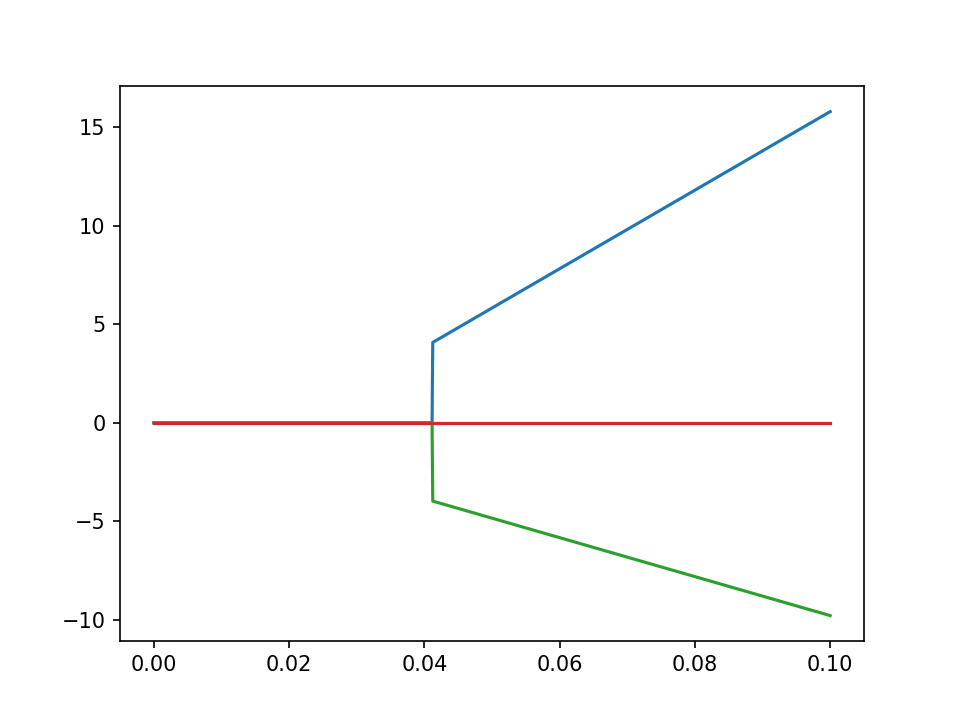

In [32]:
plt.figure()
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    plt.plot(D0s, I[i], '-')